# Variance reduction technique in simulating the price of the exotic option

## Chapter 9.8 (Simulating the price of the exotic option, p216, $Simulation, Ross, 5th$)

### Do 10000 replications and construct a 95% confidence interval for the mean option price.


In [1]:
# import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt


## Exotic Option (mariya note for barrier option)

## Vanilla Call Payoff

$$\mathop{C(K,t,v) = E[(p(t)-K]^+ = E[(v \cdot e ^W - K)^+]}$$

where $p(t)$ is the price of the stock at time $t$, $K$ is the strike price, $p(0) = v$ the start price.

\
$ln\frac{p(t+y)}{p(t)} \sim Normal(\mu t,t\sigma^2),W = \frac{p(t)}{v} \sim Normal(\mu t,t\sigma^2)$


## up-and-in call option

additional price $b$ : barrier
additional time $s$ : time maturity where $s<t$

exceicise is possible if the stock's price at time s exceeds the barrier b,the option becomes valid of $p(s)>b$

let :

$X=ln\frac{p(s)}{v},Y = ln \frac{p(t)}{p(s)},X \sim Normal(\mu t,t\sigma^2),Y \sim Normal((t-s)μ,(t-s)σ^2)$

- $P(s) = ve^X$
- $P(t) = p(s)e^Y= ve^{X+Y}$
- The payoff is :

  - $\mathop{Payoff = \underbrace{I(ve^X > b)(ve^{X+Y}-K)^+}_{I(p(s)>b)((p(t))-K)^+}}$


- ### Algorithm 1

  1. Generate $X \sim Normal(sμ,sσ^2)$
  2. If $X > ln\frac{b}{v}$:
     - then generate $Y ～ Normal((t-s)μ,(t-s)σ^2)$,$payoff = (ve^{X+Y}-K)^+$
     - else payoff 0


In [2]:
# Set parameters
v_0 = 100  # initial value in dollars
b_threshold = 120  # the value of b in dollars
k_strike = 110  # the value of k in dollars
t_time = 5  # the end time t of simulation
s_time = 2  # the time s that the option is alive
sigma = 0.2  # the value of volatility
mu = 0.05  # the value of drift
N = 100  # the number of simulations


In [3]:
# Algorithm 1
# Simulate the stock price at time s and t for N times.
ln_bv = np.log(b_threshold / v_0)  # calulate the ln of b/v_0


In [4]:
xs = [
    stats.norm(loc=s_time * mu, scale=s_time * sigma**2).rvs()
    for _ in range(N)
]

ys = [
    stats.norm(loc=(t_time - s_time) * mu, scale=(t_time - s_time) * sigma *
               2).rvs() if x > ln_bv else 0 for x in xs
]

C_ktsv = [
    np.maximum(v_0 * np.exp(x + y) - k_strike, 0) for x, y in zip(xs, ys)
]
payoff_estimated = np.mean(C_ktsv)


In [5]:
payoff_estimated


31.320111354363508

In [6]:
# 95% confidence interval for the mean option price
C_std = np.std(C_ktsv)
interval_95 = [
    payoff_estimated - 1.96 * C_std / np.sqrt(N),
    payoff_estimated + 1.96 * C_std / np.sqrt(N)
]
interval_95


[-1.8982115199502338, 64.53843422867725]

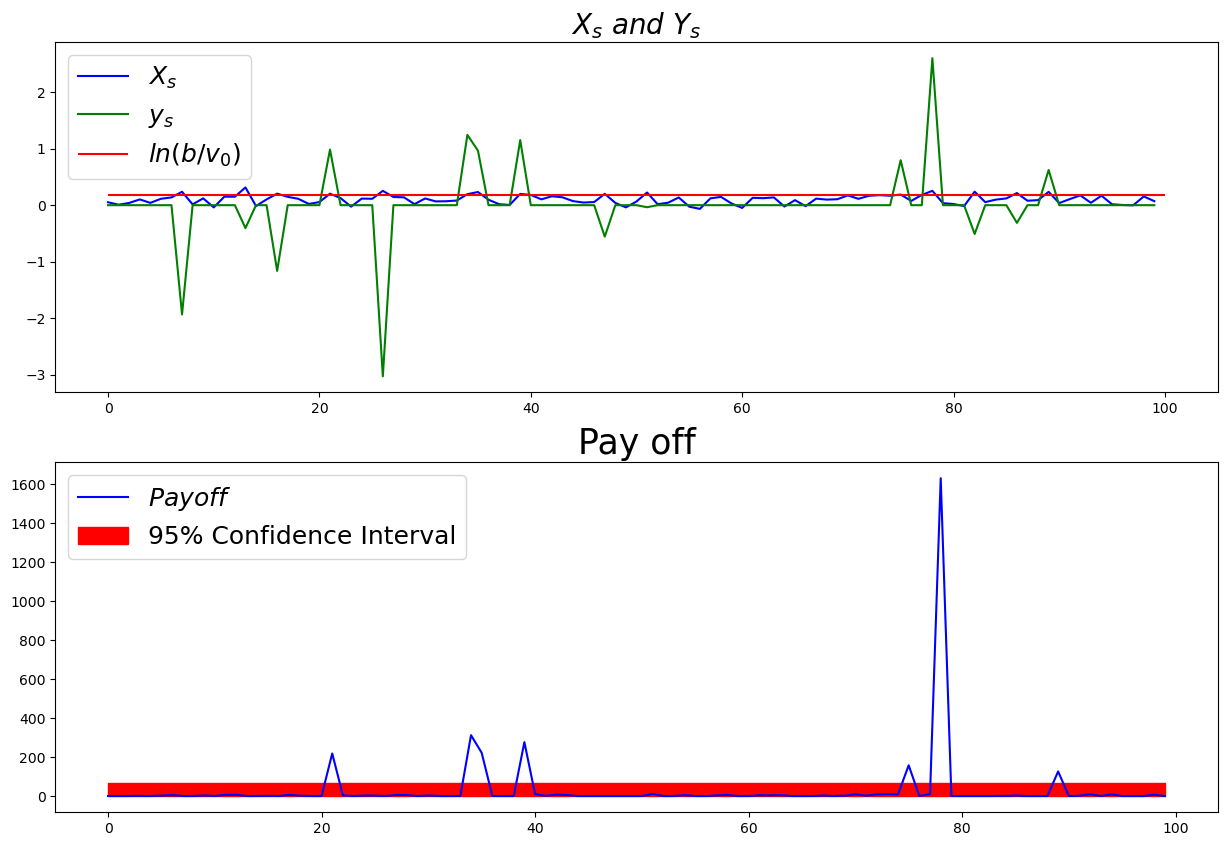

In [7]:
_, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(xs, color='b', label='$X_s$')
axes[0].plot(ys, color='g', label='$y_s$')
axes[0].hlines(ln_bv, 0, N, color='r', label='$ln(b/v_0)$')

axes[0].set_title('$X_s\ and\ Y_s$', fontsize=20)
axes[0].legend(fontsize=18)

axes[1].plot(C_ktsv, color='b', label='$Payoff$')
axes[1].set_title('Pay off', fontsize=25)
axes[1].fill_between(range(N),
                     interval_95[0],
                     interval_95[1],
                     color='r',
                     label='95% Confidence Interval')
axes[1].legend(fontsize=18)
plt.show()


In [8]:
# 100 replications is not enough, suggest 100000


- ### Algorithm with variance reduction

  - $R$ - Payoff
  - $\mathop{E(R)= E[R|X > ln(\frac{b}{v})]\bar{Φ}[\frac{ln(\frac{b}{v})-sμ}{σ\sqrt{s}}]}$
  - Steps:
    1. Generate $X> ln(\frac{b}{v})$
    2. set $\mathop{Estimator = C(K,t-s,ve^X) \bar{Φ}(\frac{ln(\frac{b}{v})- sμ}{σ√{s}})}$
  - With k simulations:
    - $\mathop{Estimator = \bar{Φ}(\frac{ln(\frac{b}{v})-sμ}{σ\sqrt{s}})\frac{1}{k}∑_{i=1}^{k}C(K,t-s,ve^{X_i})}$
      - $\mathop{X = sμ + σ\sqrt{s}Z}$, where $Z>c ≡ \frac{ln(\frac{b}{v})-sμ}{σ\sqrt{s}}$
      - If c <= 0, generate Z with getting Z > c;
      - If c > 0,use rejection technique accoding to the algorithm


In [9]:
# Algorithm wiht variance reduction
# ln_bv = np.log(b_threshold / v_0)
c_ = (np.log(b_threshold / v_0) - s_time * mu) / (sigma * np.sqrt(s_time))
phi_bar = 1 - stats.norm(0, 1).pdf(c_)
phi_bar


0.6176021710147366

In [10]:
xs = [
    stats.norm(loc=s_time * mu, scale=s_time * sigma**2).rvs()
    for _ in range(N)
]

ys = [
    stats.norm(loc=(t_time - s_time) * mu, scale=(t_time - s_time) * sigma *
               2).rvs() if x > ln_bv else 0 for x in xs
]

C_ktsv_vr = [
    np.maximum(phi_bar * v_0 * np.exp(x + y) - k_strike, 0)
    for x, y in zip(xs, ys)
]
payoff_estimated_vr = np.mean(C_ktsv_vr)


In [11]:
payoff_estimated_vr


11.234478504900302

In [12]:
C_std_vr = np.std(C_ktsv_vr)
# #95% C.I. uses 1.96 z-value
interval_95_vr = [
    payoff_estimated - 1.96 * C_std_vr / np.sqrt(N),
    payoff_estimated + 1.96 * C_std_vr / np.sqrt(N)
]
interval_95_vr


[20.799473817238116, 41.8407488914889]

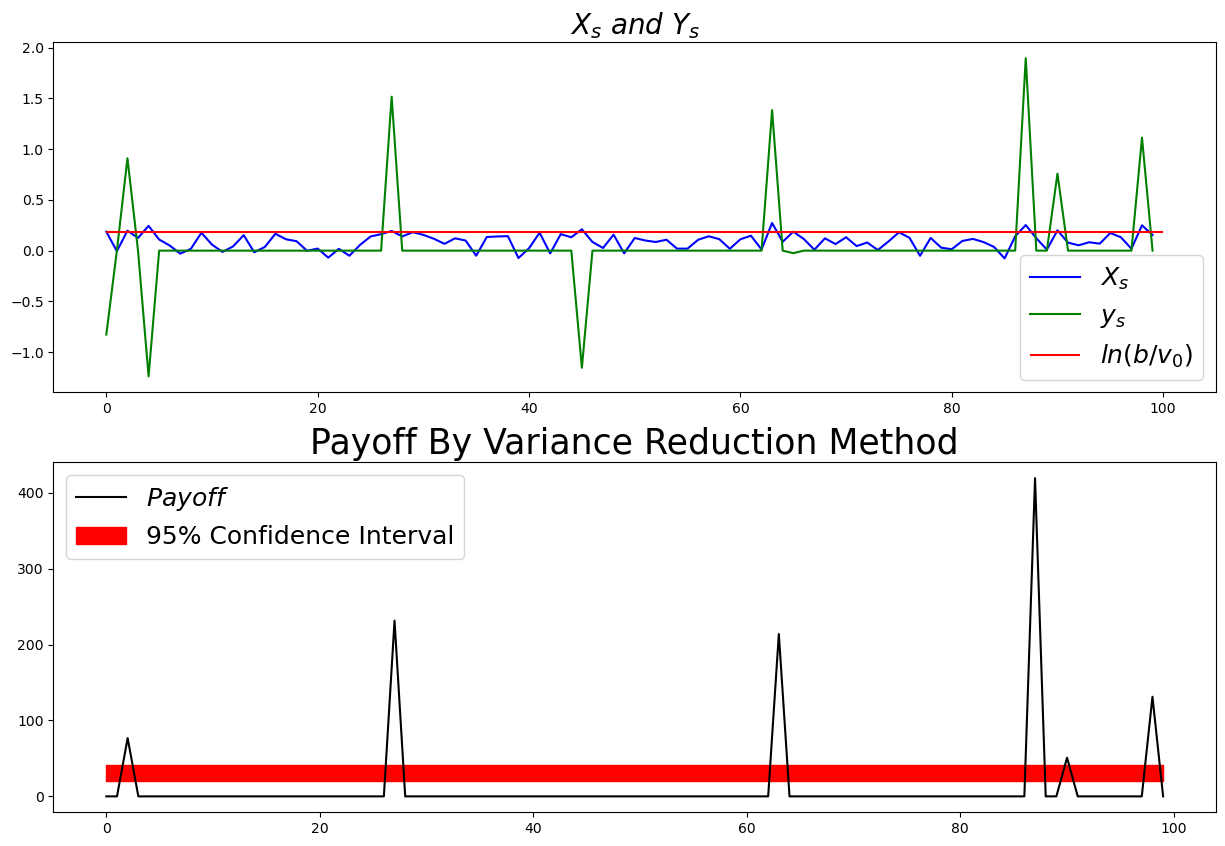

In [13]:
_, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(xs, color='b', label='$X_s$')
axes[0].plot(ys, color='g', label='$y_s$')
axes[0].hlines(ln_bv, 0, N, color='r', label='$ln(b/v_0)$')

axes[0].set_title('$X_s\ and\ Y_s$', fontsize=20)
axes[0].legend(fontsize=18)

axes[1].plot(C_ktsv_vr, color='black', label='$Payoff$')
axes[1].fill_between(range(N),
                     interval_95_vr[0],
                     interval_95_vr[1],
                     color='r',
                     label='95% Confidence Interval')
axes[1].set_title('Payoff By Variance Reduction Method', fontsize=25)
axes[1].legend(fontsize=18)
plt.show()


In [14]:
C_std_vr, C_std


(53.676722128190775, 169.48123915466195)

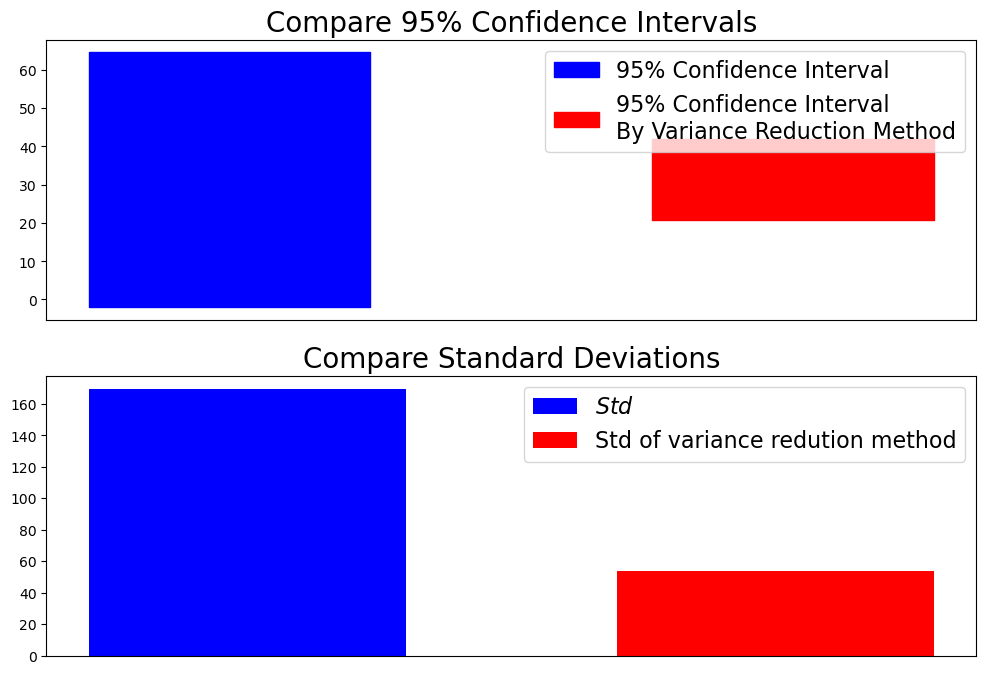

In [15]:
_, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].fill_between(np.linspace(0, 1),
                     interval_95[0],
                     interval_95[1],
                     color='b',
                     label='95% Confidence Interval')
axes[0].fill_between(
    np.linspace(2, 3),
    interval_95_vr[0],
    interval_95_vr[1],
    color='r',
    label='95% Confidence Interval\nBy Variance Reduction Method')
axes[0].get_xaxis().set_visible(False)
axes[0].set_title('Compare 95% Confidence Intervals', fontsize=20)
axes[0].legend(fontsize=16)
axes[1].bar(np.linspace(0, 1), C_std, width=0.2, color='b', label='$Std$')
axes[1].bar(np.linspace(2, 3),
            C_std_vr,
            width=0.2,
            color='r',
            label='Std of variance redution method')
axes[1].get_xaxis().set_visible(False)
axes[1].set_title('Compare Standard Deviations', fontsize=20)
axes[1].legend(fontsize=16)
plt.show()


In [16]:
std_reduced = (C_std-C_std_vr) / C_std
print(
    f"With variance reduction method, the standard deviation is reduced by {round(std_reduced*100,2)}%.")


With variance reduction method, the standard deviation is reduced by 68.33%.
